In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style

from polar_coord import make_data_sin, make_dataset_sin
from polar_coord import make_model_sin_math

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Plot style 
plot_style()

In [5]:
# Make datasets for sin
n = 3600
ds_p2c, ds_c2p, d2_p2p, ds_c2c = make_dataset_sin(n)

In [6]:
# Unpack one example batch
theta, y = list(ds_p2c.take(1))[0]
theta, y = theta.numpy(), y.numpy()

# Review data contents
print(f'theta: min={np.min(theta):+8.5}, max={np.max(theta):+8.5}')
print(f'    y: min={np.min(y):+8.5}, max={np.max(y):+8.5}')

theta: min= -1.5708, max= +1.5708
    y: min=    -1.0, max=    +1.0


In [7]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_model_sin_math()

In [8]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()

In [9]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer)
math_c2p.compile(loss=loss, optimizer=optimizer)
math_p2p.compile(loss=loss, optimizer=optimizer)
math_c2c.compile(loss=loss, optimizer=optimizer)

In [10]:
# Evaluate the p2c model
math_p2c.evaluate(ds_p2c)

1/1 [==============================] - 0s 55ms/step - loss: 4.6015e-16


4.601469428267544e-16

In [11]:
# Evaluate the c2p model
math_c2p.evaluate(ds_c2p)

1/1 [==============================] - 0s 41ms/step - loss: 6.4945e-13


6.494470217686954e-13

In [12]:
# Evaluate the p2p model
math_p2p.evaluate(theta, theta)

3601/3601 [==============================] - 0s 47us/sample - loss: 6.4904e-13


6.490446467481708e-13

In [13]:
# Evaluate the c2c model
math_c2c.evaluate(y, y)

3601/3601 [==============================] - 0s 46us/sample - loss: 7.0153e-16


7.01525834862032e-16

In [36]:
def compile_and_fit(model, ds, epochs, loss, optimizer):
    # Compile the model
    model.compile(loss=loss, optimizer=optimizer)

    # Create callbacks
    interval = epochs // 20
    cb_log = EpochLoss(interval=interval)
    cb_time = TimeHistory()
    callbacks = [cb_log, cb_time]
    
    # Fit the model
    hist = model.fit(ds, epochs=epochs, callbacks=callbacks, verbose=0)
    # Add the times to the history
    hist.history['time'] = cb_time.times
    
    return hist

In [15]:
# Build the NN model of y=sin(theta)
model_sin_64 = make_model_sin([64])

In [16]:
# keras.utils.plot_model(model_sin)

In [17]:
model_sin_64.summary()

Model: "model_sin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
theta (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
phi_1 (Dense)                (None, 64)                128       
_________________________________________________________________
y (Dense)                    (None, 1)                 65        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile
model_sin.compile(loss=loss, optimizer=optimizer)

In [19]:
# Callbacks for model_sin
cb_log = EpochLoss(interval=500)
cb_time = TimeHistory()
callbacks = [cb_log, cb_time]

In [20]:
hist_sin_64 = model_sin.fit(ds_p2c, epochs=10000, callbacks=callbacks, verbose=0)
hist_sin_64.history['time'] = cb_time.times

W0621 21:44:56.050252 28960 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 0500; loss 5.14e-03; elapsed 0:00:09
Epoch 1000; loss 4.74e-03; elapsed 0:00:15
Epoch 1500; loss 4.05e-03; elapsed 0:00:21
Epoch 2000; loss 2.89e-03; elapsed 0:00:27
Epoch 2500; loss 1.21e-03; elapsed 0:00:33
Epoch 3000; loss 1.46e-04; elapsed 0:00:39
Epoch 3500; loss 3.43e-05; elapsed 0:00:45
Epoch 4000; loss 3.14e-05; elapsed 0:00:50
Epoch 4500; loss 2.96e-05; elapsed 0:00:56
Epoch 5000; loss 2.76e-05; elapsed 0:01:02


(<Figure size 1152x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ba81068748>)

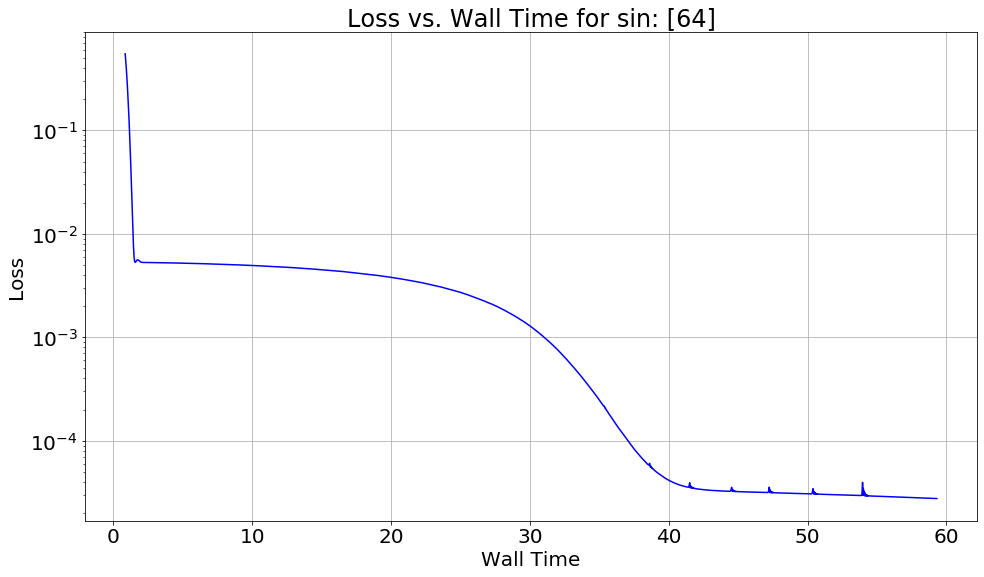

In [30]:
plot_loss_hist(hist_sin_64, 'sin: [64]')

In [37]:
model_sin_16_16 = make_model_sin([16, 16])

In [38]:
model_sin_16_16.summary()

Model: "model_sin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
theta (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
phi_1 (Dense)                (None, 16)                32        
_________________________________________________________________
phi_2 (Dense)                (None, 16)                272       
_________________________________________________________________
y (Dense)                    (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [39]:
hist_sin_16_16 = compile_and_fit(model=model_sin_16_16, 
                                 ds=ds_p2c, 
                                 epochs=10000,
                                 loss=keras.losses.MeanSquaredError(), 
                                 optimizer=keras.optimizers.Adam())

W0621 21:57:08.002240 28960 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 0250; loss 1.49e-04; elapsed 0:00:03
Epoch 0500; loss 1.28e-04; elapsed 0:00:06
Epoch 0750; loss 1.19e-04; elapsed 0:00:09
Epoch 1000; loss 1.16e-04; elapsed 0:00:12
Epoch 1250; loss 1.13e-04; elapsed 0:00:15
Epoch 1500; loss 1.09e-04; elapsed 0:00:18
Epoch 1750; loss 1.05e-04; elapsed 0:00:21
Epoch 2000; loss 1.00e-04; elapsed 0:00:24
Epoch 2250; loss 9.43e-05; elapsed 0:00:27
Epoch 2500; loss 8.79e-05; elapsed 0:00:30
Epoch 2750; loss 8.15e-05; elapsed 0:00:33
Epoch 3000; loss 7.36e-05; elapsed 0:00:36
Epoch 3250; loss 6.60e-05; elapsed 0:00:39
Epoch 3500; loss 5.82e-05; elapsed 0:00:41
Epoch 3750; loss 5.08e-05; elapsed 0:00:44
Epoch 4000; loss 4.24e-05; elapsed 0:00:47
Epoch 4250; loss 3.48e-05; elapsed 0:00:50
Epoch 4500; loss 2.67e-05; elapsed 0:00:53
Epoch 4750; loss 1.95e-05; elapsed 0:00:56
Epoch 5000; loss 1.34e-05; elapsed 0:00:59


(<Figure size 1152x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ba92d26da0>)

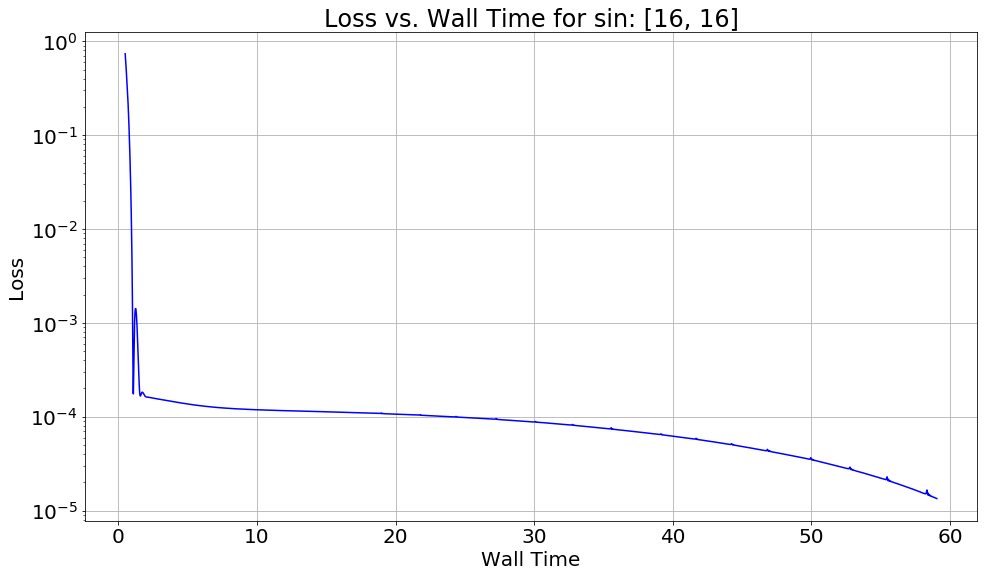

In [40]:
plot_loss_hist(hist_sin_16_16, 'sin: [16, 16]')

In [42]:
model_sin_32_32 = make_model_sin([32, 32])

In [43]:
model_sin_32_32.summary()

Model: "model_sin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
theta (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
phi_1 (Dense)                (None, 32)                64        
_________________________________________________________________
phi_2 (Dense)                (None, 32)                1056      
_________________________________________________________________
y (Dense)                    (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [44]:
hist_sin_32_32 = compile_and_fit(model=model_sin_32_32, 
                                 ds=ds_p2c, 
                                 epochs=10000,
                                 loss=keras.losses.MeanSquaredError(), 
                                 optimizer=keras.optimizers.Adam())

W0621 22:02:22.741170 28960 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 0500; loss 5.19e-04; elapsed 0:00:07
Epoch 1000; loss 9.93e-05; elapsed 0:00:12
Epoch 1500; loss 8.86e-05; elapsed 0:00:18
Epoch 2000; loss 7.88e-05; elapsed 0:00:24
Epoch 2500; loss 6.97e-05; elapsed 0:00:30
Epoch 3000; loss 6.17e-05; elapsed 0:00:36
Epoch 3500; loss 5.44e-05; elapsed 0:00:42
Epoch 4000; loss 4.68e-05; elapsed 0:00:48
Epoch 4500; loss 3.82e-05; elapsed 0:00:54
Epoch 5000; loss 2.91e-05; elapsed 0:01:00
Epoch 5500; loss 1.89e-05; elapsed 0:01:06
Epoch 6000; loss 8.70e-06; elapsed 0:01:12
Epoch 6500; loss 2.56e-06; elapsed 0:01:18
Epoch 7000; loss 1.83e-05; elapsed 0:01:24
Epoch 7500; loss 1.11e-06; elapsed 0:01:30
Epoch 8000; loss 3.05e-06; elapsed 0:01:36
Epoch 8500; loss 5.44e-06; elapsed 0:01:41
Epoch 9000; loss 2.73e-06; elapsed 0:01:47
Epoch 9500; loss 9.18e-07; elapsed 0:01:53
Epoch 10000; loss 8.82e-07; elapsed 0:02:00


(<Figure size 1152x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ba8bf24e80>)

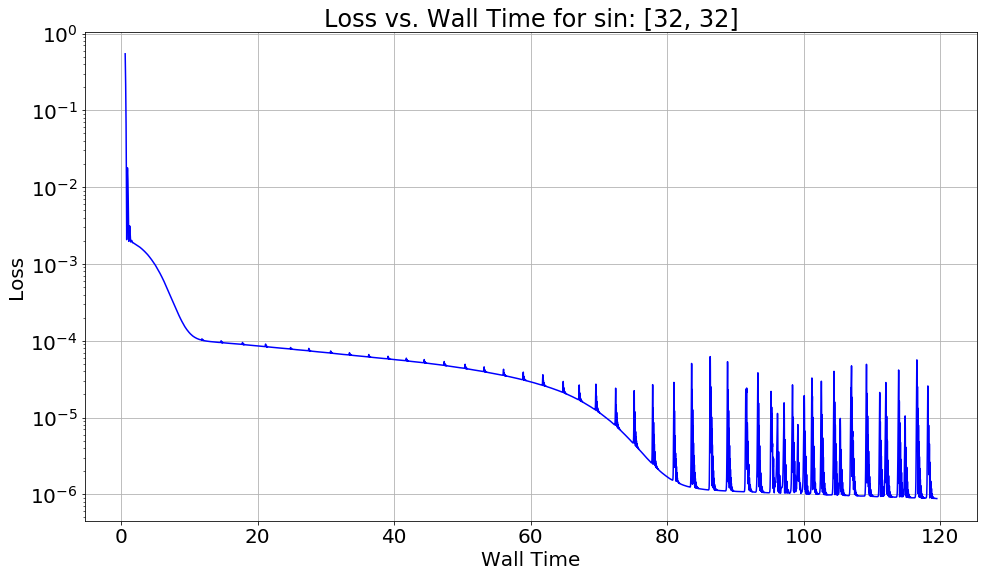

In [45]:
plot_loss_hist(hist_sin_32_32, 'sin: [32, 32]')